In [1]:
import sys 
sys.path.append("../models/")
from Basin import Basin 
from functions import wmape, plot_style
from import_functions import import_posterior, import_projections_deaths, get_averted_deaths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
colors = plot_style("../fonts/Encode_Sans_Condensed/")

countries =['Sri Lanka', 'El Salvador', 'Morocco', 'Bolivia', 'Honduras',
            'Philippines', 'Indonesia', 'Pakistan', 'Rwanda', 'Bangladesh',
            'Kyrgyzstan', 'Egypt', 'Mozambique', 'Afghanistan', 'Angola',
            'Ghana', 'Zambia', "Côte d'Ivoire", 'Kenya', 'Uganda']
end_date = datetime(2021, 10, 1)

# countries start_date
start_dates = {}
for country in countries:
    # countries with earlier start 
    if country in ['Egypt', 'Mali', 'Zimbabwe']:
        start_dates[country] = datetime(2020, 10, 1)
    elif country in ['Bolivia', 'Mozambique', 'El Salvador', 'Togo', 'Rwanda', 'Zambia', "Senegal", 'Ghana']:    
        start_dates[country] = datetime(2020, 11, 1)
    else:
        start_dates[country] = datetime(2020, 12, 1)


def get_deaths_df(country, scenario, vaccine, scaled=True):
    dates = np.arange(start_dates[country], end_date, timedelta(days=1))
    deaths = import_projections_deaths(country=country, scenario=scenario, vaccine=vaccine, scaled=scaled,  path="./projections_october/")
    basin = Basin(country, "../basins/")
    # get real deaths (first month excluded for the delay Delta)
    real_deaths = basin.epi_data_deaths.loc[(basin.epi_data_deaths["date"] >= start_dates[country]) &
                                            (basin.epi_data_deaths["date"] < end_date)]["daily"][33:].reset_index(drop=True)

    df_deaths = pd.DataFrame(data={"real_deaths": real_deaths.values, 
                                   "sim_deaths": np.median(deaths, axis=0)[33:],
                                   "sim_deaths_q1": np.quantile(deaths, axis=0, q=0.05)[33:], 
                                   "sim_deaths_q2": np.quantile(deaths, axis=0, q=0.95)[33:]}, index=dates[33:])
    df_deaths = df_deaths.resample("W").sum()
    return df_deaths


def get_wMAPE(country, scenario, vaccine, scaled=True):
    df_deaths = get_deaths_df(country, scenario, vaccine, scaled=True)
    wmape_err = wmape(df_deaths.real_deaths, df_deaths.sim_deaths)
    return wmape_err


def plot_real_deaths(ax, country):
    df_deaths = get_deaths_df(country, scenario="data-driven", vaccine="age-order", scaled=True)
    p1 = ax.scatter(df_deaths.index, df_deaths.real_deaths, color=colors[1], s=10)


def plot_deaths_scenario(ax, country, scenario, vaccine, color, linestyle, scaled=True):
    df_deaths = get_deaths_df(country, scenario=scenario, vaccine=vaccine, scaled=scaled)
    p2, = ax.plot(df_deaths.index, df_deaths.sim_deaths, color=color, linestyle=linestyle)
    p3 = ax.fill_between(df_deaths.index, df_deaths.sim_deaths_q1, df_deaths.sim_deaths_q2, linewidth=0, alpha=0.3, color=color)
    

../models/functions.py:286: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


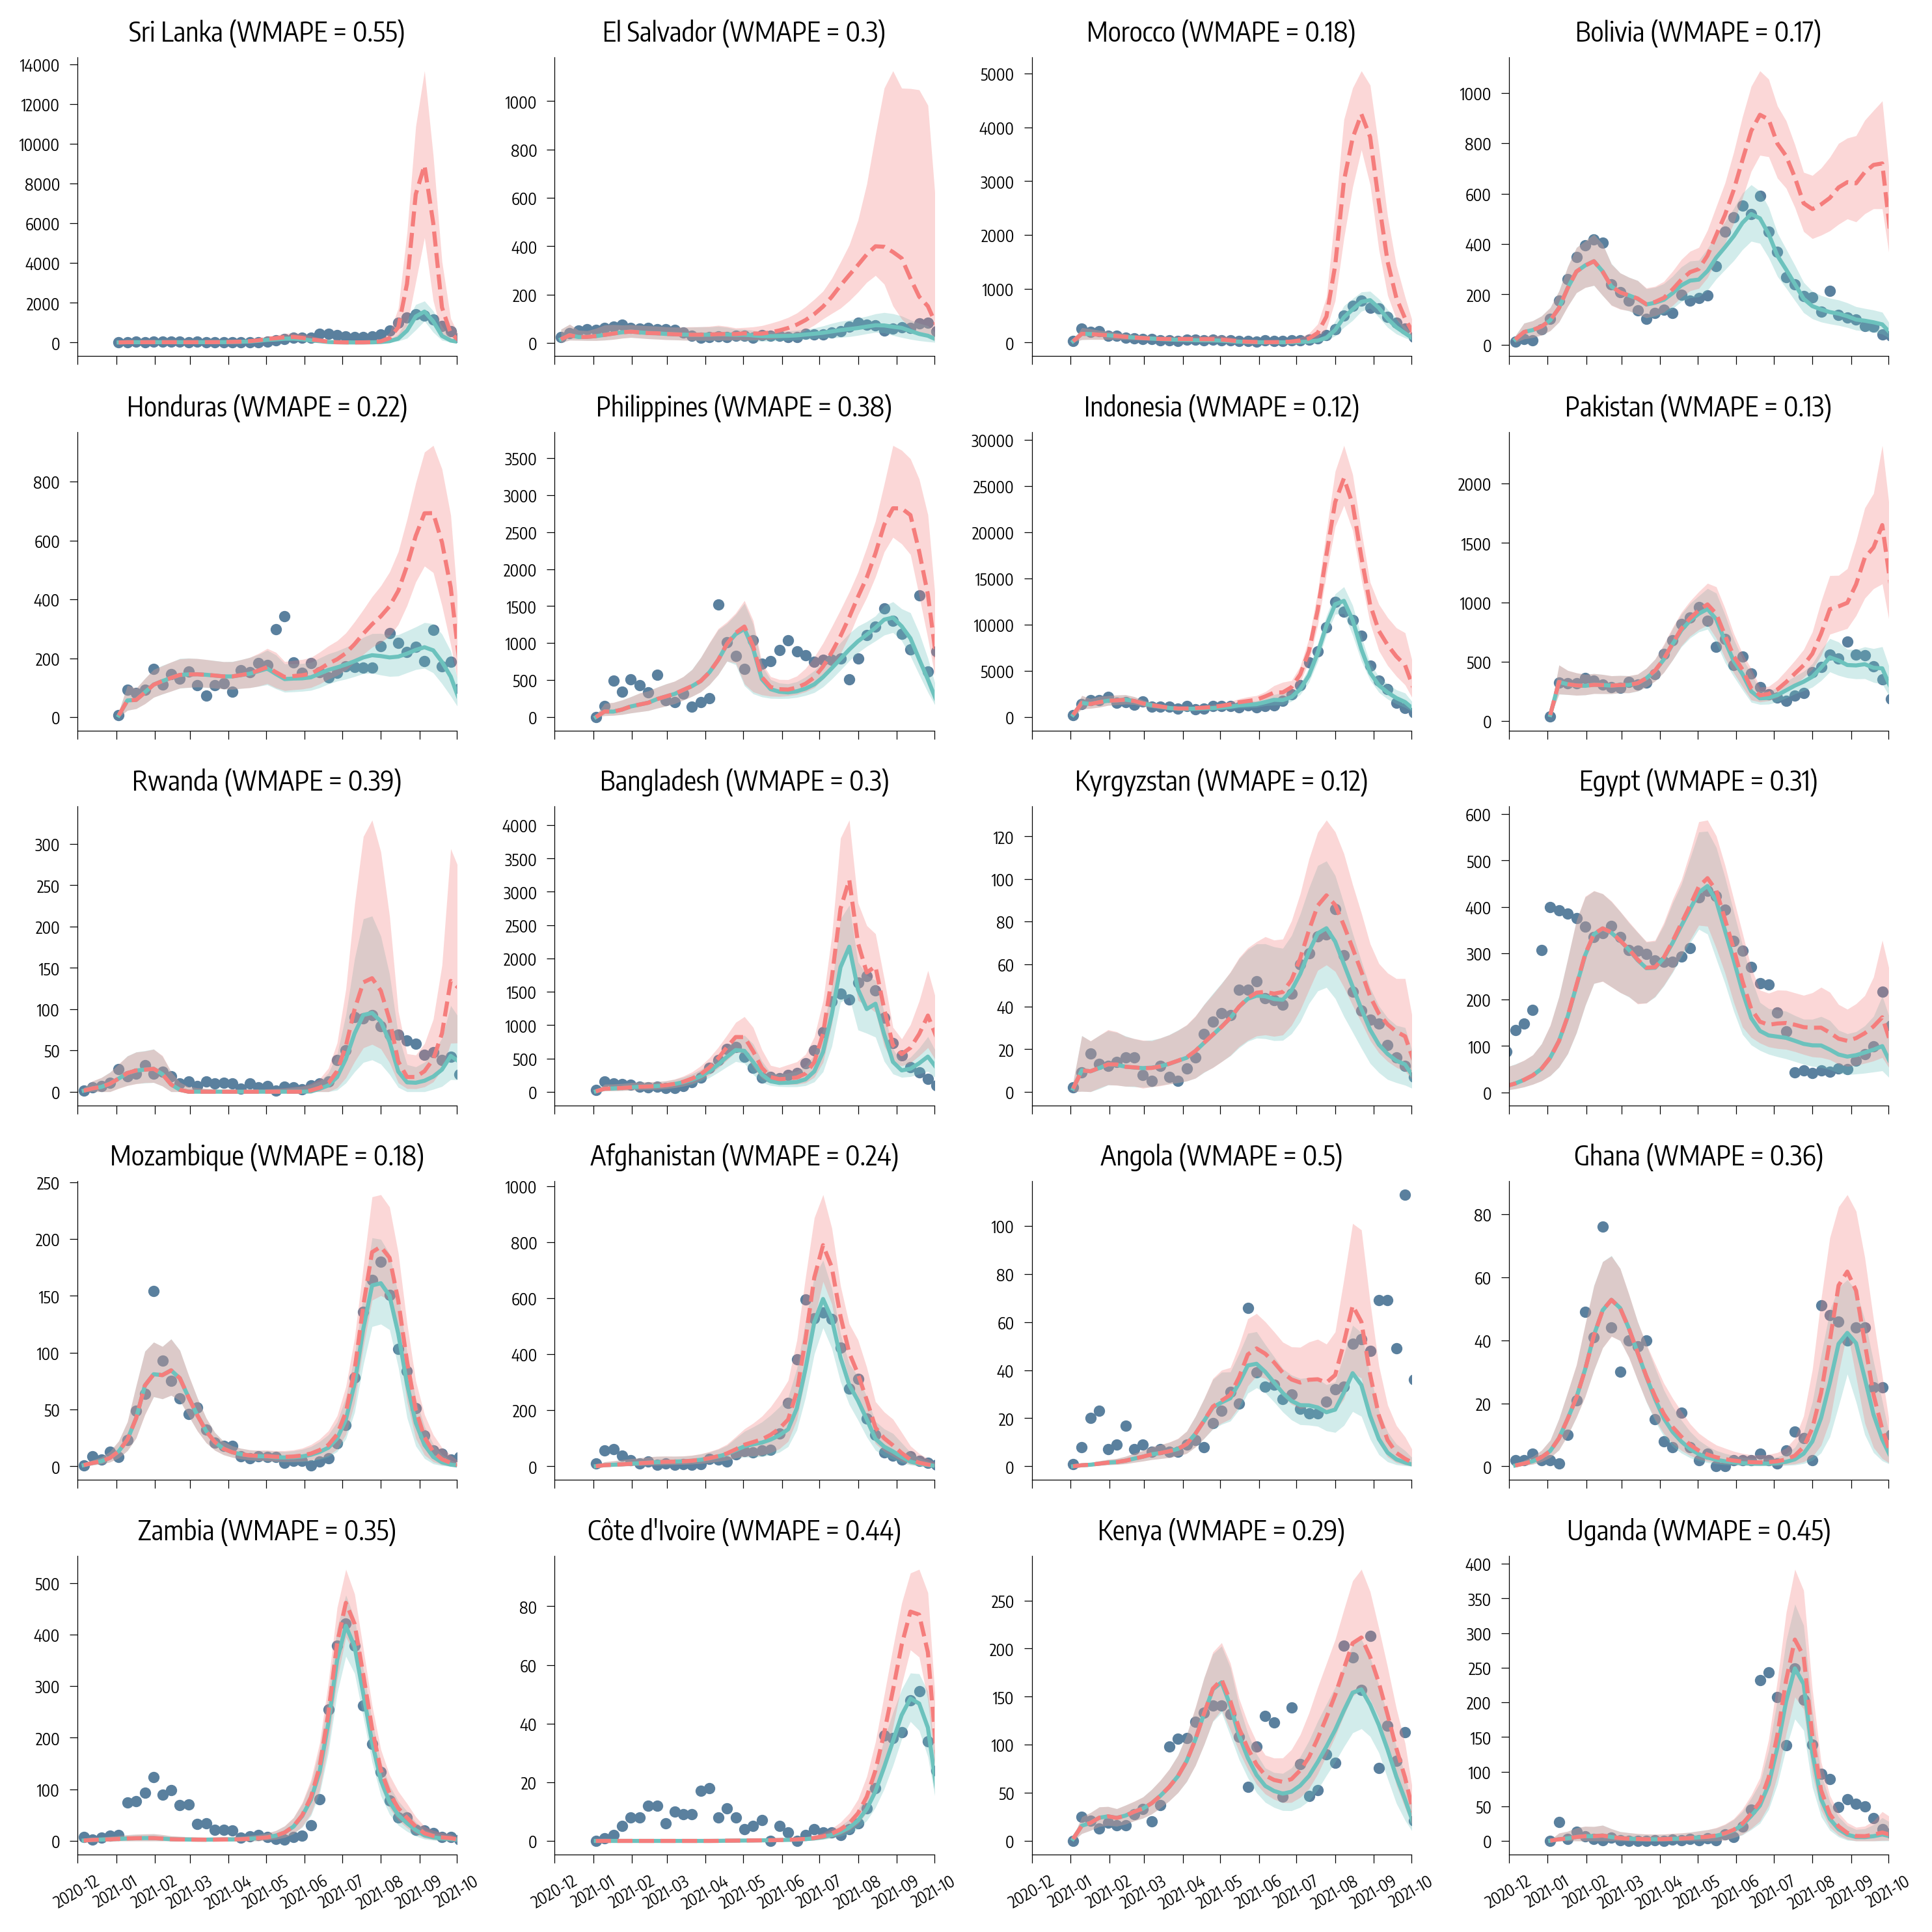

In [2]:
fig, axes = plt.subplots(dpi=300, ncols=4, nrows=5, sharex=True, figsize=(10,10))

for country, ax in zip(countries, axes.ravel()):

    plot_real_deaths(ax, country)
    plot_deaths_scenario(ax, country, scenario='data-driven', vaccine="age-order", color=colors[0], linestyle="-", scaled=True)
    plot_deaths_scenario(ax, country, scenario='data-driven', vaccine="False", color=colors[3], linestyle="--", scaled=True)

    ax.set_xlim(start_dates[country] + timedelta(days=30), end_date)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', labelsize=6, rotation=30)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlim(xmin=datetime(2020, 12, 1))

    wmape_err = get_wMAPE(country, scenario="data-driven", vaccine="age-order", scaled=True)
    title = country
    title += " (WMAPE = " + str(np.round(wmape_err, 2))+ ")"
    ax.set_title(title, fontsize=10)
    ax.set_xlim(xmax=datetime(2021, 10, 1))

plt.tight_layout()
plt.savefig("./img/fit.pdf", bbox_inches="tight")

In [3]:
def import_projections(country, scenario, baseline='data-driven', path="./projections_october/"):
    # get averted deaths in perc
    avertedDeaths_perc = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=True, path=path)
    avertedDeaths_perc_med = np.median(avertedDeaths_perc)
    return avertedDeaths_perc_med


averted_deaths, percVax = [], []
for country in countries:
    averted_deaths.append(import_projections(country, "data-driven", baseline='False'))
    basin = Basin(country, "../basins/")
    percVax.append(basin.vaccinations.loc[basin.vaccinations.Day == end_date].people_fully_vaccinated_per_hundred.values[0])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


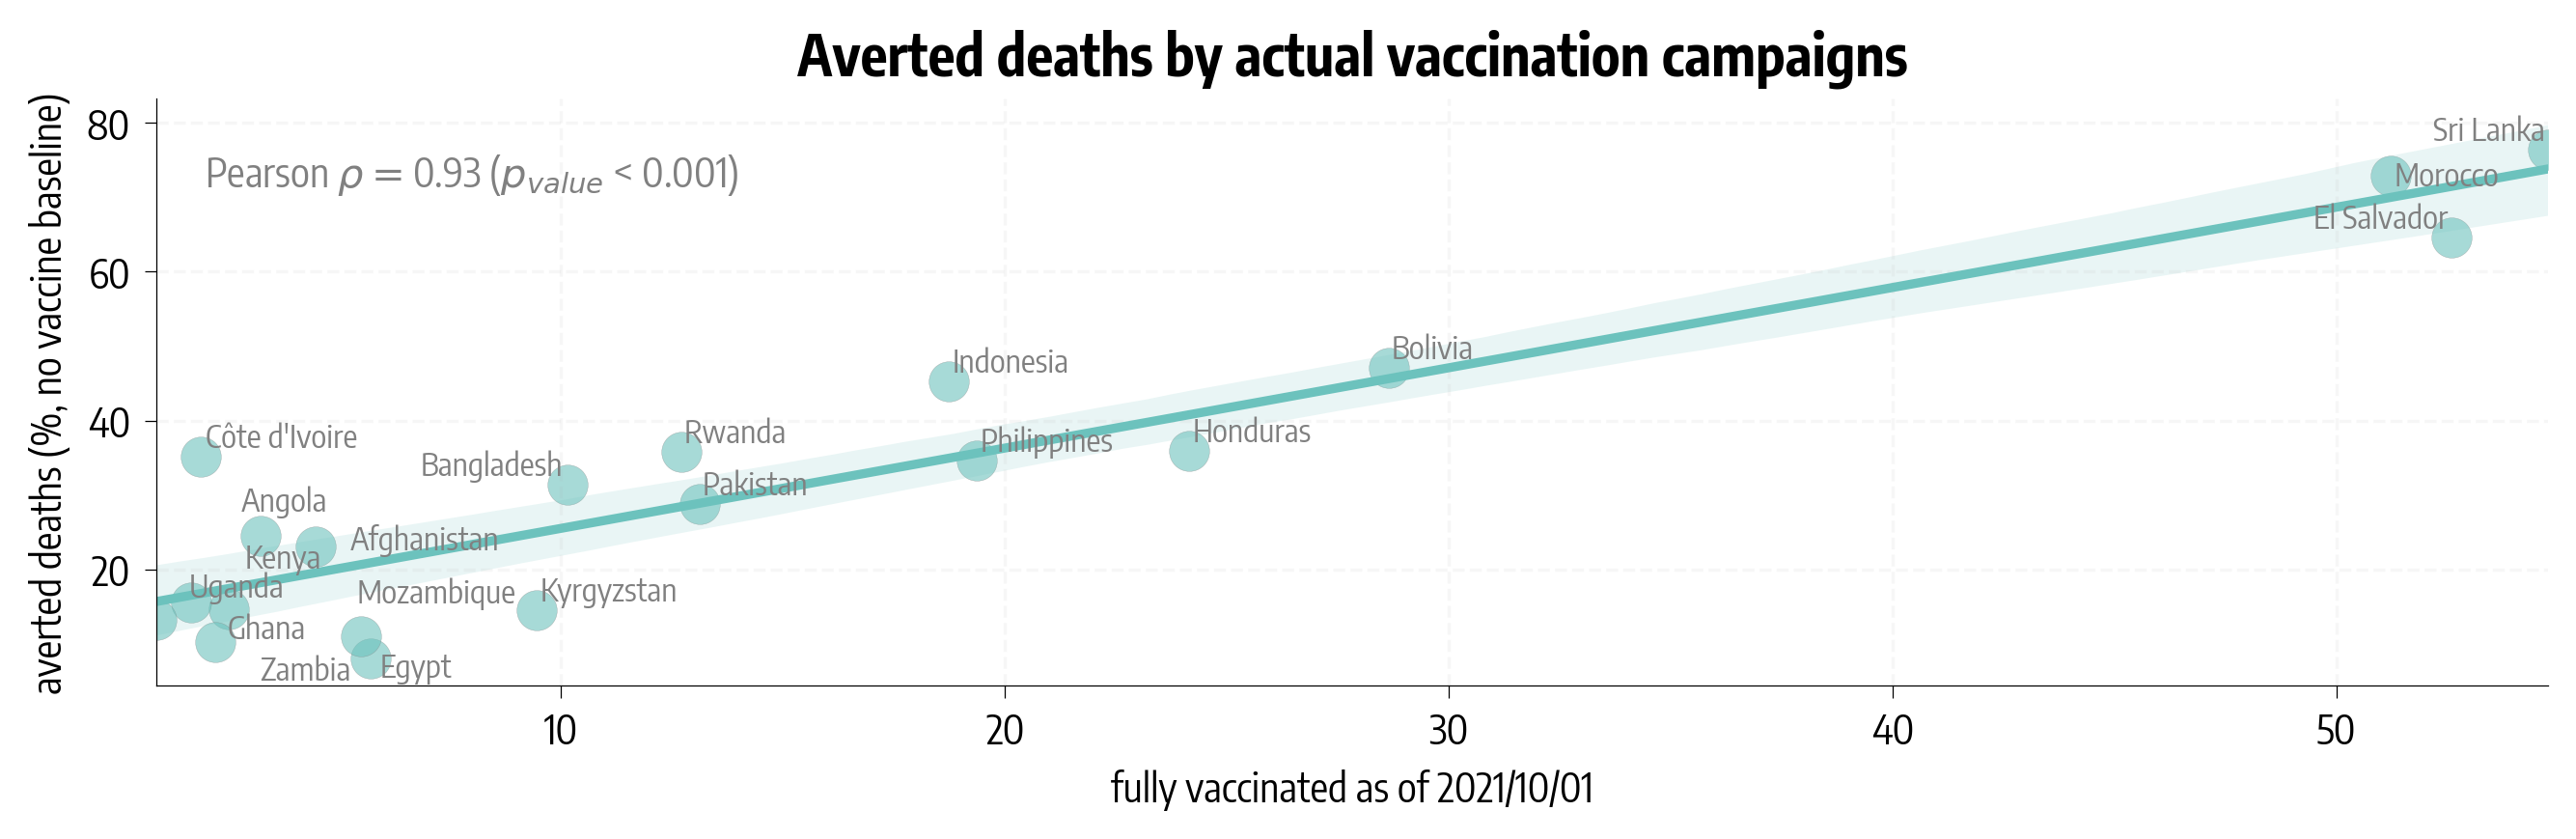

In [4]:
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import pearsonr

fig, axes = plt.subplot_mosaic([["A", "A", "A"]], dpi=300, figsize=(9, 3))

r, p = pearsonr(averted_deaths, percVax)
sns.regplot(percVax, averted_deaths, color=colors[0], ax=axes["A"], scatter_kws=dict(s=100, alpha=0.6, edgecolor="grey", linewidth=0.1))
axes["A"].set_xlabel("fully vaccinated as of 2021/10/01")
axes["A"].set_ylabel("averted deaths (%, no vaccine baseline)")

texts = []
for i in range(len(countries)):
    weight="normal"
    color="grey"
    texts.append(axes["A"].text(percVax[i], averted_deaths[i], countries[i], ha='center', va='center', color=color, fontsize=8, weight=weight))
adjust_text(texts)

axes["A"].set_title("Averted deaths by actual vaccination campaigns", weight="bold", fontsize=14)
axes["A"].spines["top"].set_visible(False)
axes["A"].spines["right"].set_visible(False)
axes["A"].grid(alpha=0.1, linestyle="--")

label = "Pearson $\\rho = $" + str(np.round(r, 2)) + " ($p_{value}$ < 0.001)"
axes["A"].annotate(xy=(0.02, 0.85), xycoords="axes fraction", text=label, color="grey")
plt.tight_layout()

plt.savefig("./img/averted_deaths_actual.pdf", bbox_inches="tight")